In [2]:
import numpy as np
import time
import math
import modules as md
import nbodysolver as nbs
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


#------------------------------------------------------------------------------------------
#Units and conversions:
#------------------------------------------------------------------------------------------
#code units: Rsun, Msun, G=1, ...
c_SI       = 299792458.0        #m/s
M_sun_SI   = 1.989*(10.**30.)   #kg
R_sun_SI   = 695800000.         #m
R_bull_SI = 1000 #m 
AU_SI      = 149597871000.      #m 
G_new_SI   = 6.67*(10.**(-11.)) #m**3 kg**(-1) s**(-2)
AU_U       = AU_SI/R_sun_SI                             #from dist AU to code units (U)
kmsec_U    = 1000./np.sqrt(G_new_SI*M_sun_SI/R_bull_SI)  #from vel km/sec to code units (U)
time_U     = 1/np.sqrt(G_new_SI*M_sun_SI/R_bull_SI**3) #from CU to second np.sqrt((R_bull_SI)/(G_new_SI*M_sun_SI)) #from code units(U) to time sec
#Rsch_1Msun_unitRsun = ((2.*G_new_SI*(1.*M_sun_SI))/(c_SI**2.))/R_sun_SI
c_CU = c_SI/1000*kmsec_U

# Newtonian


In [3]:
#Acceleration

def acc(r,m): #r position, m mass
    a = np.zeros((len(r),3)) #Create acceleration vector
    for i in range(len(r)): #Range is size of timesteps or position steps
        for j in range(len(r)): #For each particle
            if (i != j):
                rrel = r[i]-r[j]
                rn = (rrel**2).sum()**(1./2) 
                a[i] += -(rrel)*m[j]/(rn**3.0) #Acceleration at each time step 
    return a # return acceleration


def Jerk(r,v,m): #position, velocity, mass
    Je = np.zeros((len(r),3)) #Define the Jerk
    for i in range(len(r)):
        for j in range(len(r)):
            if (i != j):
                rrel = r[i]-r[j]
                vrel = v[i]-v[j]
                rn = (rrel**2).sum()**(1./2) # dot product
                vn = (vrel**2).sum()**(1./2)
                rvd = ((rrel)*(vrel)).sum()
                Je[i] += - m[j]*((vrel)/rn**3.0 - 3.*(rvd*rrel/(rn**5.0))) 
    return Je;

#Hermite Update Dynamical Timestep

def HermiteUpdatedtp(dt, r, v, m): 
    a = acc(r, m)          # current acceleration
    adot = Jerk(r,v,m)     # current jerks
    rp = r + dt*v + dt**2/2 * a + dt**3/6* adot   # predict
    vp = v + dt*a + dt**2/2 * adot
    ap = acc(rp,m)          # predicted acceleration
    adotp = Jerk(rp,vp,m)  # predicted jerks 
    vp = v + dt/2*(a+ap) - dt**2/12*(adotp-adot)  # correct
    rp = r + dt/2*(v + vp) - dt**2/12 *(ap-a) 
    
    #compute some other things to find the best value for the timestep
    a2 = (1./dt**2)*(-6*(a-ap)-dt*(4*adot + 2*adotp))
    a3 = (1./dt**3)*(-12*(a-ap)-6*dt*(adot + adotp))
    ac = a + adot*dt + (1./2)*(dt**2)*a2 + (1./6)*(dt**2)*a3    
    a2c = a2 + dt*a3    
    acn = ((ac**2).sum())**(1./2) #dot product
    a2cn = ((a2c**2).sum())**(1./2)
    adotpn = ((adotp**2).sum())**(1./2)
    a3n = ((a3**2).sum())**(1./2)
    
    dtp = (accu*(acn*a2cn + adotpn**2)/(adotpn*a3n + a2cn**2))**(1./2)
    
    return rp, vp, dtp #Most basic output
    #return rp,vp,ap,adotp,dtp

#Hermite Update Dynamical Timestep

def Hermite4thdtp(pri,sec, bina, nsteps, Dt):
    
    N=2
    m = np.ones(N)#/N #Remove the N if not necessary
    m[0]=pri.mass
    m[1]=sec.mass
    
    r_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    v_res = np.zeros((2,3,nsteps))
    dtp = np.zeros(nsteps)
    time = np.zeros(nsteps)
    #Add to get full output
    #a_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    #adot_res = np.zeros((2,3,nsteps))
    r_res[:,:,0] = bina.r.copy()
    v_res[:,:,0] = bina.v.copy()
    dtp[0] = Dt

    #Basic output      
    for i in range(1,nsteps):
        (r_res[:,:,i],v_res[:,:,i],dtp[i]) = HermiteUpdatedtp(dtp[i-1], r_res[:,:,i-1], v_res[:,:,i-1], m)
        time[i] = time[i-1] + dtp[i-1]
        #Time limit
        if time[i] >= timelimit:
            break
            
    
    #More output    
    #for i in range(1,nsteps):
    #    (r_res[:,:,i],v_res[:,:,i],a_res[:,:,i],adot_res[:,:,i],dtp[i]) = HermiteUpdatedtp(dtp[i-1], r_res[:,:,i-1], v_res[:,:,i-1], m)
    #    time[i] = time[i-1] + dtp[i-1]
    #    #Time limit
    #    if time[i] >= timelimit:
    #        break
            
    r_res = r_res[:,:,:i]
    v_res = v_res[:,:,:i]
    dtp = dtp[:i]
    time = time[:i]
    #Add for complete output
    #a_res = a_res[:,:,:i]
    #adot_res = adot_res[:,:,:i]

    
    
    return r_res, v_res, time #a_res, adot_res, dtp, time
    #return r_res, v_res, a_res, adot_res, dtp, time #Complete output



## Test 

In [4]:
#Define black holes
bh1 = md.Particle("BH",5,0,0) #stellar type, mass, radius, spin. At the momento for black holes choose r=0 and will set the Schwarzchild radius
bh2 = md.Particle("BH",20,0,0)

#Define binary
bh1bh1 = md.Binary(bh1, bh1, bh1.radi*50, 0) ##primary, secondary, orbital distance (Rsun), eccentricity
bh1bh2 = md.Binary(bh1, bh2, bh1.radi*50, 0) ##primary, secondary, orbital distance (Rsun), eccentricity


accu = 0.001 #0.02 Set accuracy parameter
tl = 1*bh1bh2.periodct #Time of the simulation in [cpde units]
timelimit = tl #
dt = 10 #Guess a timestep
Nsteps = int(tl/dt)#Number of timesteps with the guessed timestep 

rN,vN, timeN= Hermite4thdtp(bh1,bh2, bh1bh2, Nsteps, dt)

No handles with labels found to put in legend.


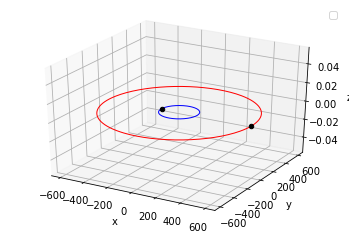

In [5]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(rN[0][0], rN[0][1], rN[0][2], 'r', linewidth=1)# Plot the BH orbit
ax.plot(rN[1][0], rN[1][1], rN[1][2], 'b', linewidth=1)# Plot the star orbit
ax.scatter3D(rN[0][0][-1], rN[0][1][-1], rN[0][2][-1], 'o', c='black') #s=100
ax.scatter3D(rN[1][0][-1], rN[1][1][-1], rN[1][2][-1], 'o', c='black') #s=10
ax.legend()
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_zticks([])
#ax.set_xlim3d(-1,1)
#ax.set_ylim3d(-1,1)
#ax.set_xlim3d(min(min(posbh1x), min(posbh2x)), max(max(posbh1x), max(posbh2x)))
#ax.set_ylim3d(min(min(posbh1y), min(posbh2y)), max(max(posbh1y), max(posbh2y)))
#ax.set_zlim3d(min(min(posbh1z), min(posbh2z)), max(max(posbh1z), max(posbh2z)))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')


#plt.savefig('Newtoniancircular10000orbitalT.png', format='png', dpi=200)#, dpi=200

plt.show()